## 1 Импорт библиотек и модулей

In [2]:
!pip install -q ydata_profiling

In [1]:
#!pip install -q hyperopt

In [3]:
%matplotlib inline

In [91]:
# для обработки ошибок 
import warnings

# для работы с данными
import pandas as pd

# для EDA анализа
import ydata_profiling

# для математических вычислений
import numpy as np

# для визуализации
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix

# для разделения данных на выборки
from sklearn.model_selection import train_test_split

# модели машинного обучения
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# для подбора гиперпараметров
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# для расчёта качества моделей
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# для расчёта времени выполнения кода
import time

## 2 Подготовка данных
### 2.1 Открытие файла и изучение общей информации
Считаем данные из csv-файла в датафрейм, сохраним в переменную `df` и проведём EDA анализ.

In [12]:
def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv')
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv')
    ydata_profiling.ProfileReport(df, progress_bar=False, correlations={"auto": {"calculate": False}})\
    .to_file(name + '.html')
    return df

In [13]:
df = read_eda('users_behavior')

[Посмотреть анализ.](https://www.dropbox.com/s/6h1goknw903mtx7/users_behavior.html?dl=0)

- **В данных 3214 строк, 5 столбцов, 2 типа данных: float64, int64.**
- **Проблем не обнаружено.**

### 2.2 Разбивка на выборки
Разделим данные на признаки (`features`) и целевой признак (`target`).

In [30]:
x = df.drop('is_ultra', axis=1)
y = df['is_ultra']

Разделим данные на обучающую и тестовую выборки.

In [55]:
RANDOM_STATE = 0

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

Проверим размеры выборок.

In [20]:
print('Размер обучающей выборки:', x_train.shape)
print('Размер тестовой выборки:', x_test.shape)

Размер обучающей выборки: (2410, 4)
Размер валидационной выборки: (482, 4)
Размер тестовой выборки: (322, 4)


<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты подготовки данных:</b>
        <ol>
        <li>Общая информация о данных изучена.</li>
        <li>Данные разбиты на выборки.</li>
        </ol>
   </p>  
</div>

## 3 Работа с моделями
### 3.1 Обучение
Обучим разные модели без параметров и выберем лучшую.

In [56]:
def quality(mdl, return_qual=0):
    scores = cross_val_score(mdl, x_train, y_train, cv=5, scoring='accuracy')
    quality = scores.mean()
    print('Качество:', quality)
    
    if return_qual == 1:
        return quality

In [57]:
%%time
quality(LogisticRegression())

Качество: 0.7228215767634855
CPU times: total: 78.1 ms
Wall time: 84.8 ms


In [58]:
%%time
quality(DecisionTreeClassifier(random_state=RANDOM_STATE))

Качество: 0.7008298755186722
CPU times: total: 62.5 ms
Wall time: 72.8 ms


In [59]:
%%time
quality(RandomForestClassifier(random_state=RANDOM_STATE))

Качество: 0.7908713692946059
CPU times: total: 3.28 s
Wall time: 3.3 s


**Лучшим себя показал случайный лес, подберём для него гиперпараметры при помощи байесовской оптимизации.**

### 3.2 Подбор гиперпараметров

In [60]:
state = np.random.default_rng(RANDOM_STATE)

valid_scores = []

def hp_slctns(model, space):
    def func(args):
        mdl = model.set_params(**args)
        scores = cross_val_score(mdl, x_train, y_train, cv=5, scoring='accuracy', 
                                 error_score='raise')
        final_score = -sum(scores) / len(scores)
        valid_scores.append(final_score)
        return {'loss': final_score, 'status': STATUS_OK, 'model':mdl}
    
    trials = Trials()
    best = fmin(func,
                space=space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=10, 
                show_progressbar=True, 
                rstate=state)
    best_model = trials.best_trial['result']['model']
    
    print('Лучшие гиперпараметры:', best)
    return best_model

In [61]:
rf_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 3, 100, 1)),
        'max_features': hp.choice('max_features', range(1,5)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 50, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 50, 1)), 
        'n_estimators': hp.choice('n_estimators', range(1,20))
        }

best_rf = hp_slctns(model=RandomForestClassifier(random_state=RANDOM_STATE), space=rf_space)

100%|███████████████████████████████████████████████| 10/10 [00:02<00:00,  4.12trial/s, best loss: -0.8029045643153527]
Лучшие гиперпараметры: {'max_depth': 39.0, 'max_features': 1, 'min_samples_leaf': 21.0, 'min_samples_split': 36.0, 'n_estimators': 10}


Посмотрим, как при изменении гиперпараметров меняется точность.

In [53]:
def dynamics_plot():
    _, ax = plt.subplots(figsize=(10, 5))
    ax.plot(valid_scores)
    ax.grid()
    
    plt.title('Динамика точности модели' + "\n", size=18)
    plt.xlabel('Номер попытки', size=16)
    plt.ylabel('Точность', size=16)
    plt.show()

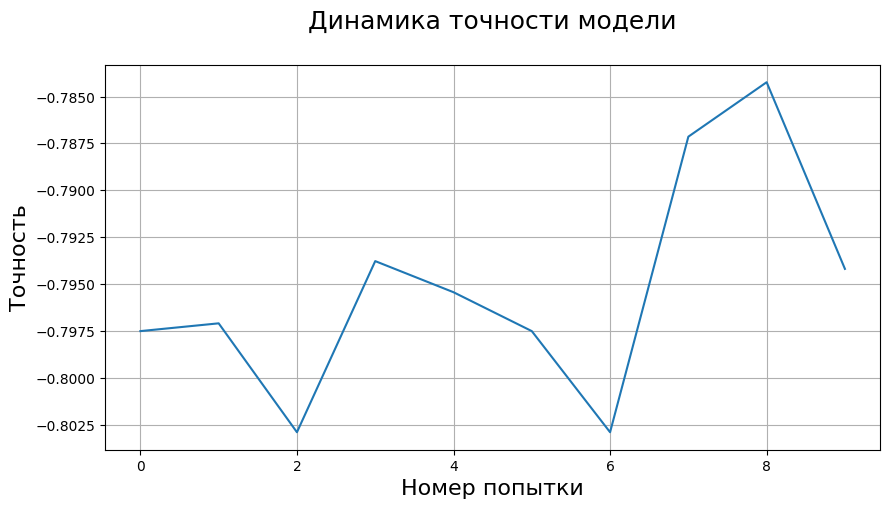

In [54]:
dynamics_plot()

### 3.3 Сравнение с константной моделью
Получим качество константной модели.

In [65]:
dummy_most_frequent = quality(DummyClassifier(strategy='most_frequent'), return_qual=1)
dummy_stratified = quality(DummyClassifier(strategy='stratified'), return_qual=1)
dummy_uniform = quality(DummyClassifier(strategy='uniform'), return_qual=1)

Качество: 0.6933609958506224
Качество: 0.5659751037344398
Качество: 0.4987551867219917


Сохраним результаты лучшей константной модели в пустой датафрейм.

In [66]:
results_df = pd.DataFrame(columns=['Качество', 'Время обучения', 'Скорость предсказания'])
results_df.loc['Константная модель'] = [dummy_most_frequent, 0, 0]

Добавим строку с временем обучения, скоростью предсказания и качеством градиентного бустинга в таблицу с результатами.

In [82]:
def save_time(model, best_model, name):
    mdl = model.set_params(**best_model.get_params())
    
    start_train_timer = time.time()
    mdl.fit(x_train, y_train)
    stop_train_timer = time.time() - start_train_timer
    
    start_pred_timer = time.time()
    pred = mdl.predict(x_test)
    score = accuracy_score(y_test, pred)
    stop_pred_timer = time.time() - start_pred_timer
    
    results_df.loc[name] = [score, stop_train_timer, stop_pred_timer]
    
    return mdl, pred

In [83]:
mdl, pred = save_time(RandomForestClassifier(), best_rf, 'Случайный лес')

Рассмотрим получившеюся таблицу.

In [85]:
results_df

,Качество,Время обучения,Скорость предсказания
Константная модель,0.693361,0.000000,0.000000
Случайный лес,0.788557,0.122639,0.009004


**Модель превзошла костантную модель.**

### 3.4 Оценка предсказания

In [88]:
print('\Точность: {:.2f}\n'.format(accuracy_score(y_test, pred)))

print('Микро точность: {:.2f}'.format(precision_score(y_test, pred, average='micro')))
print('Микро полнота: {:.2f}'.format(recall_score(y_test, pred, average='micro')))
print('Микро F1-мера: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))

print('Макро точность: {:.2f}'.format(precision_score(y_test, pred, average='macro')))
print('Макро полнота: {:.2f}'.format(recall_score(y_test, pred, average='macro')))
print('Макро F1-мера: {:.2f}\n'.format(f1_score(y_test, pred, average='macro')))

print('Взвешенная точность: {:.2f}'.format(precision_score(y_test, pred, average='weighted')))
print('Взвешенная полнота: {:.2f}'.format(recall_score(y_test, pred, average='weighted')))
print('Взвешенная F1-мера: {:.2f}'.format(f1_score(y_test, pred, average='weighted')))

print('\nОтчёт классификации\n')
print(classification_report(y_test, pred))

\Точность: 0.79

Микро точность: 0.79
Микро полнота: 0.79
Микро F1-мера: 0.79

Макро точность: 0.77
Макро полнота: 0.70
Макро F1-мера: 0.72

Взвешенная точность: 0.78
Взвешенная полнота: 0.79
Взвешенная F1-мера: 0.77

Отчёт классификации

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       558
           1       0.73      0.49      0.59       246

    accuracy                           0.79       804
   macro avg       0.77      0.70      0.72       804
weighted avg       0.78      0.79      0.77       804



Построим марицу ошибок.

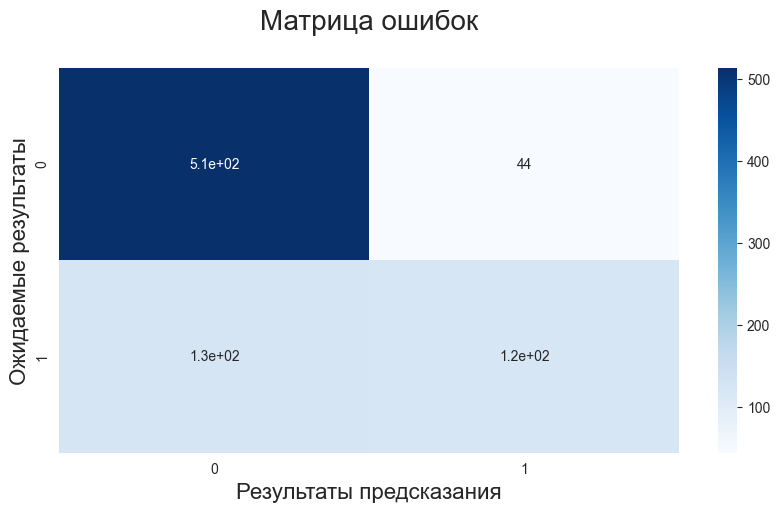

In [93]:
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues')
sns.set_style('white')
heatmap.set_title('Матрица ошибок' + "\n", fontsize=20);
heatmap.set_xlabel('Результаты предсказания', fontsize=16);
heatmap.set_ylabel('Ожидаемые результаты', fontsize=16);
plt.show()

### 3.4 Анализ важности признаков

In [80]:
def feature_importances():
    importances = mdl.feature_importances_
    sorted_idx = importances.argsort()
    
    plt.figure(figsize=(10, 4))
    plt.barh(range(x_train.shape[1]), importances[sorted_idx])
    plt.yticks(range(x_train.shape[1]), x.columns[sorted_idx])
    plt.xlabel('Важность признаков', fontsize=16)
    plt.title('График важности признаков' + '\n', fontsize=20)
    plt.grid(True)
    plt.show()

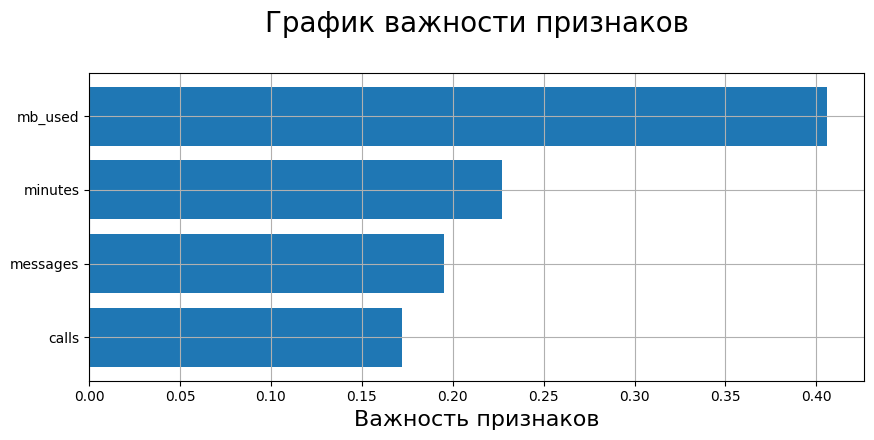

In [81]:
feature_importances()

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты работы с моделями:</b>
        <ol>
        <li>Разные модели обучены.</li>
        <li>Лучшая модель найдена, сравнена с константной и проверена на тестовой выборке.</li>
        <li>Предсказание оценено.</li>
        <li>Проведён анализ важности признаков.</li>
        </ol>
   </p>  
</div>

## 6 Отчёт

<hr style="color: steelblue; background-color: steelblue; height: 4px; border: none;">

### Описание ключевых шагов решения
1. При подготовке данных была изучена общая информация о данных и данные были разбиты на выборки.
1. Были обучены разные модели и выбрана лучшая.
1. Лучшая модель была сравнена с константной и протестирована на тестовой выборке.
1. Был проведён анализ важности признаков.

***

### Описание модели
Модель — `RandomForestClassifier`.

Гиперпараметры:
- `random_state` = 220523
- `max_depth` = 39
- `max_features` = 1
- `min_samples_leaf` = 21
- `n_estimators` = 10
- `min_samples_split` = 36

***

### Итоговая метрика
accuracy 0.788557	

<hr style="color: steelblue; background-color: steelblue; height: 4px; border: none;">